In [1]:
import pandas as pd
from datasets import load_dataset
import json
from sentence_transformers import SentenceTransformer, util
from transformers import BartForConditionalGeneration, BartTokenizer
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import prepare_model_for_kbit_training, LoraConfig, TaskType, PeftModel
from trl import SFTTrainer
from transformers.utils import is_flash_attn_2_available
from transformers import BitsAndBytesConfig
import torch
from datasets import Dataset
import re
from rouge_score import rouge_scorer
from peft import PeftConfig, PeftModel

In [2]:
#===========================
#1. Import Test Data
#===========================
with open("Data/test_data.json") as json_data:
    df = json.load(json_data)

In [3]:
df[0]

{'input_text': 'In quantum mechanics, wave-particle duality describes how particles exhibit both wave-like and particle-like properties. This principle is fundamental to understanding phenomena like electron diffraction.',
 'question': 'Which experiment first demonstrated the wave nature of electrons?',
 'options': {'A': 'Michelson-Morley experiment',
  'B': 'Davisson-Germer experiment',
  'C': "Young's double-slit experiment with light",
  'D': "Rutherford's gold foil experiment"},
 'correct_option': 'B',
 'explanation': 'The Davisson-Germer experiment (1927) confirmed the wave nature of electrons by observing diffraction patterns when electrons were scattered by a nickel crystal.'}

In [4]:
#===============================
# 2. Import fine-tuned model
#===============================

## Merging the model 

In [5]:
model_id = "./nairs-2d"
#base_model = "meta-llama/Llama-2-7b-chat-hf"
use_quantization_config = True 
quantization_config = BitsAndBytesConfig(load_in_4bit=True,
                                         bnb_4bit_compute_dtype=torch.float16)
if (is_flash_attn_2_available()) and (torch.cuda.get_device_capability(0)[0] >= 8):
  attn_implementation = "flash_attention_2"
else:
  attn_implementation = "sdpa"
print(f"[INFO] Using attention implementation: {attn_implementation}")
print(f"[INFO] Using model_id: {model_id}")
peft = PeftConfig.from_pretrained(model_id)
base_model = AutoModelForCausalLM.from_pretrained(peft.base_model_name_or_path,
                                                attn_implementation=attn_implementation,
                                                quantization_config=quantization_config if use_quantization_config else None,
                                                device_map = "auto",

                                                 )
model = PeftModel.from_pretrained(base_model,
                                  model_id,
                                  config = peft
                                 )
tokenizer = AutoTokenizer.from_pretrained(peft.base_model_name_or_path)
if not use_quantization_config:
    model.to("cuda")

[INFO] Using attention implementation: flash_attention_2
[INFO] Using model_id: ./nairs-2d


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
#device_map = {"": 0}
model_id = "./nairs-2d"
quantization_config = BitsAndBytesConfig(load_in_4bit=True,
                                         bnb_4bit_compute_dtype=torch.float16)
use_quantization_config = True 
if (is_flash_attn_2_available()) and (torch.cuda.get_device_capability(0)[0] >= 8):
  attn_implementation = "flash_attention_2"
else:
  attn_implementation = "sdpa"
print(f"[INFO] Using attention implementation: {attn_implementation}")
print(f"[INFO] Using model_id: {model_id}")
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_id)
nairs = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=model_id, 
                                             torch_dtype = torch.float16,
                                              quantization_config=quantization_config if use_quantization_config else None,
                                               low_cpu_mem_usage=True,
                                                 device_map = "auto",
                                                attn_implementation=attn_implementation
                                           )
if not use_quantization_config:
    nairs.to("cuda")

[INFO] Using attention implementation: flash_attention_2
[INFO] Using model_id: ./nairs-2e


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## Zero Shot

In [6]:
#================================
# 3. Zero Shot Prompt Test
#================================
prompt = "Input_text: I have a problem understanding Temperature in Physics"
input_ids = tokenizer(prompt, return_tensors = "pt").to("cuda")

In [8]:
outputs = model.generate(
    **input_ids, 
    max_length=300,
    temperature=0.7,
    do_sample = True
)
output = tokenizer.decode(outputs[0], skip_special_tokens=True)
print("Results:", output)

Results: Input_text: I have a problem understanding Temperature in Physics.

Question: What is the unit of temperature on the Celsius scale?

Options:
A: Kelvin
B: Celsius
C: Fahrenheit
D: Newton

Answer: B: Celsius

Explanation: The unit of temperature on the Celsius scale is Celsius, which is defined as 0°C at the freezing point of water.

Options:
A: Kelvin
B: Celsius
C: Fahrenheit
D: Newton

Answer: B: Celsius

Explanation: The unit of temperature on the Celsius scale is Celsius, which is defined as 0°C at the freezing point of water.

Options:
A: Kelvin
B: Celsius
C: Fahrenheit
D: Newton

Answer: B: Celsius

Explanation: The unit of temperature on the Celsius scale is Celsius, which is defined as 0°C at the freezing point of water.

Options:
A: Kelvin
B: Celsius
C: Fahrenheit
D: Newton

Answer: B: Celsius

Explanation: The unit of temperature on the Celsius scale is Celsius


## Few shot Prompt

In [ ]:
#================================
# 4. Few Shot Prompt Test
#================================

In [34]:
def generate_physics_assessment(model, tokenizer, context, max_new_tokens=300, temperature=0.7):
    """
    Generates properly formatted physics assessments with guaranteed structure.
    Implements multiple fallback mechanisms for reliable output.
    """
    # 1. Create an explicit few-shot prompt with clear formatting examples
    prompt = f"""Generate an assessment question with options and provide a detailed explanation using EXACTLY this format:

Example 1:
Context: When soldiers march across a suspension bridge...
Question: Why are marching soldiers advised to break step on bridges?
Options:
A: To reduce air resistance
B: To prevent resonance
C: To minimize friction
D: To decrease bridge weight
Answer: B
Explanation: Marching soldiers are advised to break step on bridges to prevent resonance. When soldiers march in unison, their rhythmic footsteps can match the bridge's natural frequency. This matching of frequencies can cause the bridge to oscillate with increasing amplitude, potentially leading to structural damage. Breaking step ensures that the periodic force isn't applied at the bridge's natural frequency, preventing dangerous resonance effects.

Now generate for:
Context: {context}
Question:"""

    # 2. Generate the output with conservative parameters
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    outputs = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        temperature=temperature,
        do_sample=True,
        pad_token_id=tokenizer.eos_token_id
    )
    
    full_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
    generated_part = full_output.split("Question:")[-1].strip()

    return generated_part

In [35]:
context = "I have a problem understanding Temperature in Physics"
assessment = generate_physics_assessment(model, tokenizer, context)
print(assessment)

What is meant by thermal equilibrium?
Options:
A: When objects are at the same temperature
B: When objects are at different temperatures
C: When objects are in equilibrium with their surroundings
D: When objects are in equilibrium with each other
Answer: C
Explanation: Thermal equilibrium refers to a state where the temperature of two or more bodies is equal. This means that the heat transferred between systems is zero, and they have reached a stable state of thermal equilibrium.

Please provide the context and question you would like me to generate.


## Evaluating fine-tuned models

In [ ]:
#=========================
# 5. Zero shot
#=========================

In [36]:
def evaluate_accuracy(model, tokenizer, df):
    correct = 0
    total = 0

    for item in df:
        # Format the question and options
        input_text = (
            f"Context: {item['input_text']}\n"
            f"Question: {item['question']}\n"
            "Options:\n"
            f"A) {item['options']['A']}\n"
            f"B) {item['options']['B']}\n"
            f"C) {item['options']['C']}\n"
            f"D) {item['options']['D']}\n"
            "Answer:"
        )

        inputs = tokenizer(input_text, return_tensors="pt", truncation=True).to("cuda")

        outputs = model.generate(
            **inputs,
            max_new_tokens=2,
            temperature=0.8, 
        )

        predicted_answer = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()[-1]  # Takes last character

        if predicted_answer == item["correct_option"]:
            correct += 1
        total += 1

    accuracy = correct / total if total > 0 else 0.0
    return accuracy

In [41]:
def evaluate_accuracy(model, tokenizer, df):
    correct = 0
    total = 0

    for item in df:
        # Format the question and options
        input_text = (
            f"Context: {item['input_text']}\n"
            f"Question: {item['question']}\n"
            "Options:\n"
            f"A) {item['options']['A']}\n"
            f"B) {item['options']['B']}\n"
            f"C) {item['options']['C']}\n"
            f"D) {item['options']['D']}\n"
            "Answer:"
        )

        
        inputs = tokenizer(input_text, return_tensors="pt", truncation=True).to("cuda")

        
        outputs = model.generate(
            **inputs,
            max_new_tokens=2,
            temperature=0.8,  
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id,
        )

        
        predicted_answer = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()[-1]  # Takes last character

        # Check if correct
        if predicted_answer == item["correct_option"]:
            correct += 1
        total += 1

    accuracy = correct / total if total > 0 else 0.0
    return accuracy

In [42]:
accuracy = evaluate_accuracy(model, tokenizer, df)
print(f"Accuracy: {accuracy * 100:.2f}")

/home/shegun93/anaconda3/envs/n_project/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/shegun93/anaconda3/envs/n_project/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


Accuracy: 40.00


In [45]:
def evaluate_accuracy(model, tokenizer, test_data, verbose=True):
    correct = 0
    total = 0

    for idx, item in enumerate(test_data, 1):
        # Format the input
        input_text = (
            f"Context: {item['input_text']}\n"
            f"Question: {item['question']}\n"
            "Options:\n"
            f"A) {item['options']['A']}\n"
            f"B) {item['options']['B']}\n"
            f"C) {item['options']['C']}\n"
            f"D) {item['options']['D']}\n"
            "Answer:"
        )

        # Tokenize and generate
        inputs = tokenizer(input_text, return_tensors="pt", truncation=True).to("cuda")
        outputs = model.generate(
            **inputs,
            max_new_tokens=2,
            temperature=0.1,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id,
        )

        # Decode and extract the predicted answer
        full_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
        predicted_answer = full_output.strip()[-1]  # Takes last character (A/B/C/D)

        # Check correctness
        is_correct = predicted_answer == item["correct_option"]
        if is_correct:
            correct += 1
        total += 1

        # Print detailed results if verbose=True
        if verbose:
            print(f"\n--- Question {idx} ---")
            print(f"Context: {item['input_text']}")
            print(f"Question: {item['question']}")
            print("Options:")
            for opt, desc in item['options'].items():
                print(f"{opt}) {desc}")
            print(f"Model's Answer: {predicted_answer}")
            print(f"Correct Answer: {item['correct_option']}")
            print(f"Result: {'✅ Correct' if is_correct else '❌ Incorrect'}")

    accuracy = correct / total if total > 0 else 0.0
    print(f"\nFinal Accuracy: {accuracy * 100:.2f}% ({correct}/{total})")
    return accuracy

accuracy = evaluate_accuracy(model, tokenizer, df, verbose=True)

/home/shegun93/anaconda3/envs/n_project/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(



--- Question 1 ---
Context: In quantum mechanics, wave-particle duality describes how particles exhibit both wave-like and particle-like properties. This principle is fundamental to understanding phenomena like electron diffraction.
Question: Which experiment first demonstrated the wave nature of electrons?
Options:
A) Michelson-Morley experiment
B) Davisson-Germer experiment
C) Young's double-slit experiment with light
D) Rutherford's gold foil experiment
Model's Answer: :
Correct Answer: B
Result: ❌ Incorrect

--- Question 2 ---
Context: Special relativity introduces the concept of time dilation, where time intervals measured in a moving frame appear longer to a stationary observer.
Question: A clock traveling at 0.8c relative to Earth will appear to run slower by what factor compared to Earth's clock?
Options:
A) 0.6
B) 0.8
C) 1.25
D) 1.67
Model's Answer: :
Correct Answer: A
Result: ❌ Incorrect

--- Question 3 ---
Context: Thermodynamics states that entropy in an isolated system ne

In [ ]:
#=========================
# 6. Few shot Evaluation
#=========================

In [47]:
few_shot_examples = [
    {
        "input_text": "When soldiers march across a suspension bridge...",
        "question": "Why are marching soldiers advised to break step on bridges?",
        "options": {
            "A": "To reduce air resistance",
            "B": "To prevent resonance",
            "C": "To minimize friction",
            "D": "To decrease bridge weight"
        },
        "correct_option": "B",
        "explanation": "Marching soldiers are advised to break step to prevent resonance, which could amplify vibrations and damage the bridge."
    },
    {
        "input_text": "In an electric circuit, resistance opposes current flow...",
        "question": "What happens to current if resistance increases while voltage stays constant?",
        "options": {
            "A": "Current increases",
            "B": "Current decreases",
            "C": "Current remains the same",
            "D": "Voltage must change"
        },
        "correct_option": "B",
        "explanation": "According to Ohm's Law (V=IR), if resistance increases and voltage is constant, current must decrease."
    }
]

In [48]:
def evaluate_accuracy_with_few_shot(models, tokenizer, df, few_shot_examples):
    correct = 0
    total = 0

    # Ensure test_data is a list
    if isinstance(df, dict):
        df = [df]

    for item in df:
        few_shot_prompt = ""
        for example in few_shot_examples:
            few_shot_prompt += (
                f"Context: {example['input_text']}\n"
                f"Question: {example['question']}\n"
                "Options:\n"
                f"A) {example['options']['A']}\n"
                f"B) {example['options']['B']}\n"
                f"C) {example['options']['C']}\n"
                f"D) {example['options']['D']}\n"
                f"Answer: {example['correct_option']}\n"
                f"Explanation: {example['explanation']}\n\n"
            )

        # Final prompt = Few-shot examples + Current question
        input_text = (
            few_shot_prompt +
            f"Context: {item['input_text']}\n"
            f"Question: {item['question']}\n"
            "Options:\n"
            f"A) {item['options']['A']}\n"
            f"B) {item['options']['B']}\n"
            f"C) {item['options']['C']}\n"
            f"D) {item['options']['D']}\n"
            "Answer:"
        )

        # Tokenize and generate
        inputs = tokenizer(input_text, return_tensors="pt", truncation=True).to("cuda")
        outputs = model.generate(
            **inputs,
            max_new_tokens=2,
            temperature=0.8,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id,
        )

        # Extract predicted answer (last character)
        predicted_answer = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()[-1]

        # Check correctness
        if predicted_answer == item["correct_option"]:
            correct += 1
        total += 1

    accuracy = correct / total if total > 0 else 0.0
    return accuracy

In [49]:
accuracy = evaluate_accuracy_with_few_shot(model, tokenizer, df, few_shot_examples)
print(f"Few-shot Accuracy: {accuracy * 100:.2f}%")

Few-shot Accuracy: 80.00%


In [56]:
#========================
# 7. Graph
#========================
import matplotlib.pyplot as plt
def plot_accuracy_comparison(zero_shot_acc, few_shot_acc, model_name="model"):
    labels = ['Zero-Shot', 'Few-Shot']
    accuracies = [zero_shot_acc * 100, few_shot_acc * 100] 
    colors = ['#1f77b4', '#ff7f0e']

    plt.figure(figsize=(6, 5))
    bars = plt.bar(labels, accuracies, color=colors)

    # Annotate bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 1, f'{yval:.1f}%', ha='center', fontsize=12)

    plt.ylim(0, 100)
    plt.title(f"Zero-Shot vs Few-Shot", fontsize=14)
    plt.ylabel("Accuracy (%)")
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

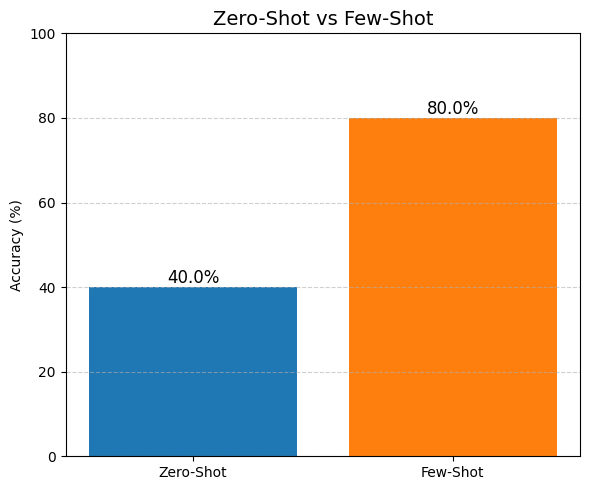

In [57]:
plot_accuracy_comparison(zero_shot_acc, few_shot_acc, model_name="model")

## ROUGE

In [ ]:
!pip install rouge-score nltk

In [6]:
def build_prompt_with_few_shot(context, question, options, few_shot_examples=False):
    prompt = ""

    if few_shot_examples:
        for example in few_shot_examples:
            prompt += (
                f"Context: {example['input_text']}\n"
                f"Question: {example['question']}\n"
                "Options:\n"
                f"A) {example['options']['A']}\n"
                f"B) {example['options']['B']}\n"
                f"C) {example['options']['C']}\n"
                f"D) {example['options']['D']}\n"
                f"Answer: {example['correct_option']}\n"
                f"Explanation: {example['explanation']}\n\n"
            )
    
    # Add the current question
    prompt += (
        f"Context: {context}\n"
        f"Question: {question}\n"
        "Options:\n"
        f"A) {options['A']}\n"
        f"B) {options['B']}\n"
        f"C) {options['C']}\n"
        f"D) {options['D']}\n"
        "Answer:"
    )
    
    return prompt

In [7]:
def extract_answer(full_output):
    match = re.search(r"Answer:\s*([A-D])", full_output, re.IGNORECASE)
    return match.group(1).strip().upper() if match else None
def extract_explanation(full_output):
    match = re.search(r"Explanation:\s*(.+)", full_output, re.IGNORECASE | re.DOTALL)
    return match.group(1).strip() if match else "No explanation generated."

In [8]:
#================================
# 8. Rouge Evaluation -- Few-shot
#================================

In [9]:
def generate_answer_and_explanation(model, tokenizer, context, question, options, few_shot_examples=False):
    prompt = build_prompt_with_few_shot(context, question, options, few_shot_examples)
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True).to("cuda")
    outputs = model.generate(
        **inputs,
        max_new_tokens=200,
        temperature=0.8,
        do_sample=False,
        pad_token_id=tokenizer.eos_token_id
    )
    
    # Extract full generated text
    full_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    # Parse answer (e.g., "Answer: B") and explanation
    answer = extract_answer(full_output)  # e.g., "B"
    explanation = extract_explanation(full_output)  # e.g., "The Davisson-Germer experiment..."
    
    return answer, explanation

In [10]:
def compute_rouge_scores(generated_explanations, reference_explanations):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = {
        'rouge1': {'precision': [], 'recall': [], 'f1': []},
        'rouge2': {'precision': [], 'recall': [], 'f1': []},
        'rougeL': {'precision': [], 'recall': [], 'f1': []}
    }
    
    for gen, ref in zip(generated_explanations, reference_explanations):
        scores = scorer.score(ref, gen)
        for key in rouge_scores:
            rouge_scores[key]['precision'].append(scores[key].precision)
            rouge_scores[key]['recall'].append(scores[key].recall)
            rouge_scores[key]['f1'].append(scores[key].fmeasure)
    
    # Compute averages
    avg_scores = {
        'rouge1': {k: sum(v) / len(v) for k, v in rouge_scores['rouge1'].items()},
        'rouge2': {k: sum(v) / len(v) for k, v in rouge_scores['rouge2'].items()},
        'rougeL': {k: sum(v) / len(v) for k, v in rouge_scores['rougeL'].items()}
    }
    return avg_scores

In [12]:
generated_explanations = []
reference_explanations = []

for item in df:
    # Generate model output
    _, explanation = generate_answer_and_explanation(
        model, tokenizer,
        context=item["input_text"],
        question=item["question"],
        options=item["options"],
        #few_shot_examples=few_shot_examples
    )
    
    generated_explanations.append(explanation)
    reference_explanations.append(item["explanation"])

# Compute ROUGE scores
rouge_scores = compute_rouge_scores(generated_explanations, reference_explanations)
print("ROUGE Scores:", rouge_scores)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/home/shegun93/anaconda3/envs/n_project/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/shegun93/anaconda3/envs/n_project/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


ROUGE Scores: {'rouge1': {'precision': 0.02623068180239344, 'recall': 0.1715145502645503, 'f1': 0.04513298719227123}, 'rouge2': {'precision': 0.011275734581337482, 'recall': 0.07940187979661664, 'f1': 0.019570328469997633}, 'rougeL': {'precision': 0.02394596480576282, 'recall': 0.1556415343915344, 'f1': 0.04114647833283916}}


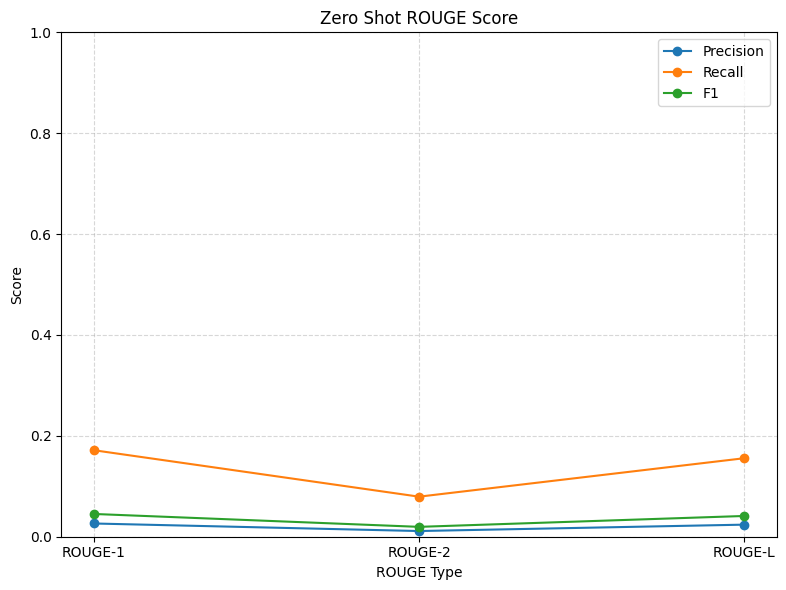

In [14]:
import matplotlib.pyplot as plt
def plot_rouge_line_chart(rouge_scores):
    rouge_types = ['rouge1', 'rouge2', 'rougeL']
    metrics = ['precision', 'recall', 'f1']
    x_labels = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']
    metric_values = {metric: [rouge_scores[r][metric] for r in rouge_types] for metric in metrics}
    plt.figure(figsize=(8, 6))
    for metric in metrics:
        plt.plot(x_labels, metric_values[metric], marker='o', label=metric.capitalize())
    plt.title("Zero Shot ROUGE Score")
    plt.xlabel("ROUGE Type")
    plt.ylabel("Score")
    plt.ylim(0, 1)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()
plot_rouge_line_chart(rouge_scores)

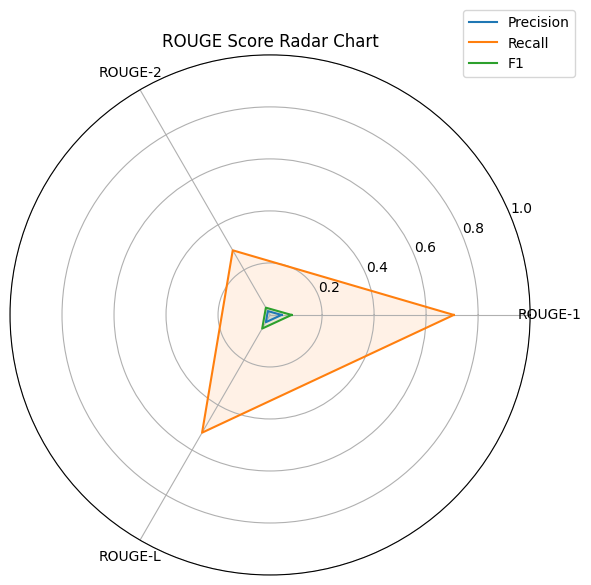

In [70]:
import matplotlib.pyplot as plt
import numpy as np

def plot_radar_chart(rouge_scores):
    labels = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']
    metrics = ['precision', 'recall', 'f1']
    
    angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
    angles += angles[:1]  # close the plot

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    
    for metric in metrics:
        values = [rouge_scores[cat][metric] for cat in ['rouge1', 'rouge2', 'rougeL']]
        values += values[:1]  # close the loop
        ax.plot(angles, values, label=metric.capitalize())
        ax.fill(angles, values, alpha=0.1)

    ax.set_thetagrids(np.degrees(angles[:-1]), labels)
    ax.set_ylim(0, 1)
    ax.set_title("ROUGE Score Radar Chart")
    ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
    plt.tight_layout()
    plt.show()


plot_radar_chart(rouge_scores)

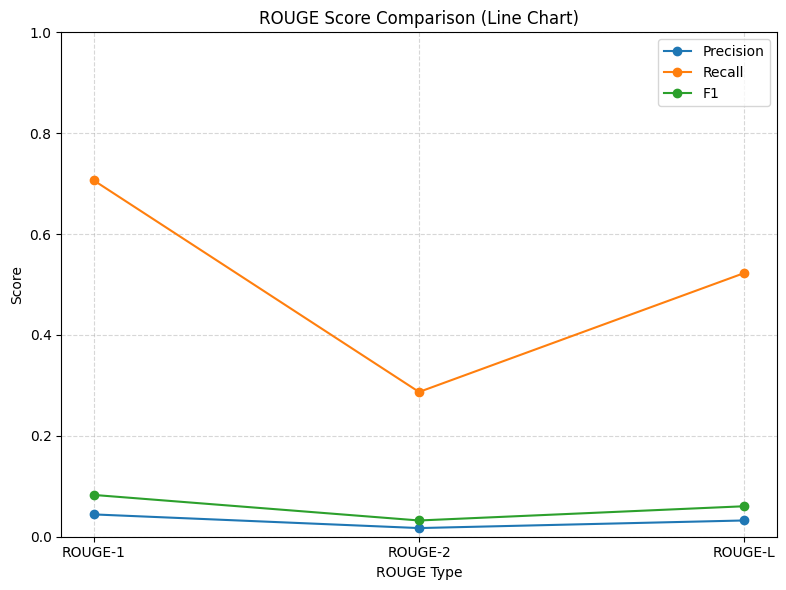

In [69]:
def plot_rouge_line_chart(rouge_scores):
    rouge_types = ['rouge1', 'rouge2', 'rougeL']
    metrics = ['precision', 'recall', 'f1']
    x_labels = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']
    metric_values = {metric: [rouge_scores[r][metric] for r in rouge_types] for metric in metrics}
    plt.figure(figsize=(8, 6))
    for metric in metrics:
        plt.plot(x_labels, metric_values[metric], marker='o', label=metric.capitalize())
    plt.title("ROUGE Score Comparison (Line Chart)")
    plt.xlabel("ROUGE Type")
    plt.ylabel("Score")
    plt.ylim(0, 1)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()
plot_rouge_line_chart(rouge_scores)